# Puzzle Piece Feature Extraction and Matching - Analysis Notebook

## 2. Extract Contours and Corners

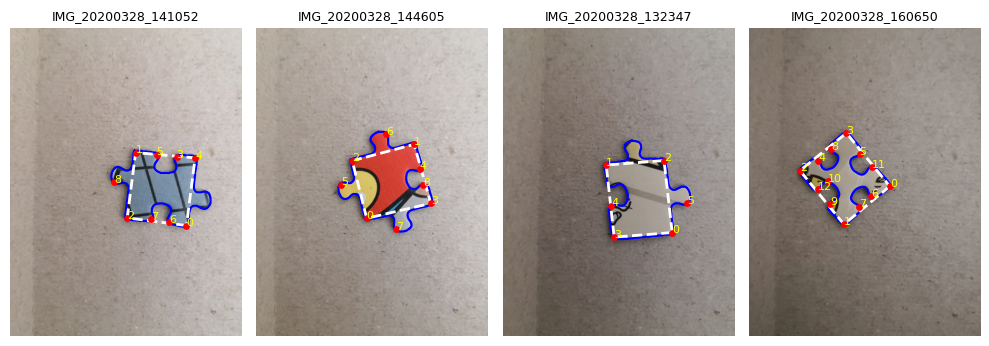

In [ ]:
def harris_corners_from_mask(mask, block_size=20, ksize=7, k=0.08, neighborhood_size=70, score_threshold=0.3, minmax_percentile=40, min_corner_spacing=50):
    mask_float = np.float32(mask)
    harris = cv2.cornerHarris(mask_float, blockSize=block_size, ksize=ksize, k=k)
    harris = harris * (mask_float > 0) # weight by mask and zero any responses outside the mask

    # Normalize Harris response to 0..1
    data = harris.copy()
    data -= data.min()
    if data.max() > 0:
        data /= data.max()

    # Threshold by score
    data[data < score_threshold] = 0.

    # Local maxima
    data_max = ndimage.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)

    # Local min & percentile-based contrast threshold
    data_min = ndimage.minimum_filter(data, neighborhood_size)
    diff = data_max - data_min
    threshold_value = np.percentile(diff[diff > 0], minmax_percentile)
    maxima[diff < threshold_value] = 0

    # Connected components -> center of mass
    labeled, num_objects = ndimage.label(maxima)
    if num_objects == 0:
        return np.empty((0, 2), dtype=int)
    yx = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects + 1)))
    
    corners = yx[:, ::-1].astype(int)  # (x, y)

    # Assign Harris strength to each detected corner
    strengths = np.array([harris[y, x] for x, y in corners])
    order = np.argsort(-strengths)  # sort descending by strength
    corners = corners[order]
    strengths = strengths[order]

    # Non-max suppression by distance, keeping strongest
    keep = []
    for i, pt in enumerate(corners):
        if len(keep) == 0:
            keep.append(i)
            continue
        dists = np.linalg.norm(corners[keep] - pt, axis=1)
        if np.all(dists >= min_corner_spacing):
            keep.append(i)

    filtered_corners = corners[keep]

    return filtered_corners

def extract_largest_contour(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    contour = max(contours, key=cv2.contourArea).squeeze()

    oriented_area = cv2.contourArea(contour, oriented=True)
    
    if oriented_area < 0:
        return contour[::-1].copy()  # Reverse contour if counter-clockwise
    
    return contour.copy()

def get_best_fitting_rect_coords(xy, d_threshold=30, perp_angle_thresh=5, min_width=150, min_height=150, debug=False):
    N = len(xy)
    if N < 4:
        if debug:
            print("Not enough points:", N)
        return None

    distances = scipy.spatial.distance.cdist(xy, xy)
    
    # Precompute angles between all points
    angles = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            dx = xy[j, 0] - xy[i, 0]
            dy = xy[j, 1] - xy[i, 1]
            angle = np.degrees(np.arctan2(dy, dx)) if dx != 0 else 90
            angles[i, j] = angles[j, i] = angle

    def angle_diff(a1, a2):
        # Compute smallest angle difference accounting for wraparound
        diff = abs(a1 - a2) % 180
        return min(diff, 180 - diff)
    
    def is_perpendicular(angle1, angle2, thresh=perp_angle_thresh):
        # Check if two angles are perpendicular
        return angle_diff(angle1, angle2 - 90) <= thresh

    possible_rectangles = []

    # Try all combinations of 4 points
    from itertools import combinations
    for combo in combinations(range(N), 4):
        pts = xy[list(combo)]
        
        # Check if distances are sufficient
        if any(distances[combo[i], combo[j]] < d_threshold for i in range(4) for j in range(i+1, 4)):
            continue
        
        # Try to order these 4 points into a valid rectangle
        # We need to find an ordering where consecutive edges are perpendicular
        from itertools import permutations
        for perm in permutations(combo):
            # Check if this ordering forms a rectangle
            edge_angles = [angles[perm[i], perm[(i+1)%4]] for i in range(4)]
            
            # Check consecutive edges are perpendicular
            valid = True
            for i in range(4):
                if not is_perpendicular(edge_angles[i], edge_angles[(i+1)%4]):
                    valid = False
                    break
            
            if valid:
                # Found a valid rectangle with this ordering
                if not any(set(perm) == set(r) for r in possible_rectangles):
                    possible_rectangles.append(list(perm))
                    break  # Found valid ordering for this combo, try next combo

    if not possible_rectangles:
        if debug:
            print("No candidate rectangles found!")
        return None

    # Polygon area
    def poly_area(pts):
        x, y = pts[:, 0], pts[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    # Filter rectangles by minimum width/height using edges
    filtered_rects = []
    edge_info = []
    for rect in possible_rectangles:
        pts = xy[rect]
        # compute consecutive edge lengths
        edges = [np.linalg.norm(pts[i] - pts[(i+1)%4]) for i in range(4)]
        width = max(edges)
        height = min(edges)
        if width >= min_width and height >= min_height:
            filtered_rects.append(rect)
            edge_info.append((width, height, edges))

    if not filtered_rects:
        if debug:
            print("No rectangles passed size filter")
        return None

    # Score rectangles
    scores = []
    for idx, rect in enumerate(filtered_rects):
        pts = xy[rect]
        area = poly_area(pts)
        mse = 0
        for i in range(4):
            # Get the two edge vectors
            v1 = pts[(i+1)%4] - pts[i]
            v2 = pts[(i+2)%4] - pts[(i+1)%4]
            
            # Compute angle between vectors using dot product
            cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            cos_angle = np.clip(cos_angle, -1, 1)  # Numerical stability
            angle_deg = np.degrees(np.arccos(cos_angle))
            
            # We want 90°, so measure deviation
            deviation = abs(angle_deg - 90)
            mse += deviation ** 2

        mse = mse / 4  # Average squared error

        width, height, edges = edge_info[idx]
        squareness = height / width
        score = area * squareness * scipy.stats.norm(0, 150).pdf(mse)
        scores.append(score)
        if debug:
            print(
                f"Combo {rect}: width={width:.1f}, height={height:.1f}, "
                f"edges={edges}, angle_mse={mse:.1f}, area={area:.1f}, score={score:.2f}"
            )

    best_rect_idx = filtered_rects[np.argmax(scores)]
    if debug:
        print(f" -> Selected best rectangle: {best_rect_idx} with score {scores[np.argmax(scores)]:.2f}")

    return xy[best_rect_idx]

def extract_contour_and_candidate_corners(mask):
    contour = extract_largest_contour(mask)
    if contour is None:
        return None, None, None

    # Harris corner response
    mask_float = np.float32(mask)
    harris = cv2.cornerHarris(mask_float, blockSize=20, ksize=7, k=0.08)
    harris = harris * (mask_float > 0)

    corners = harris_corners_from_mask(mask)

    # --- Try to find rectangle from filtered corners ---
    if corners.shape[0] >= 4:
        try:
            best_rect = get_best_fitting_rect_coords(corners)
        except Exception:
            best_rect = None
    else:
        best_rect = None

    return contour, corners, best_rect

def extract_contour_and_corners(mask, epsilon_factor=0.02):
    contour = extract_largest_contour(mask)

    corners = harris_corners_from_mask(mask)

    # Try to find rectangle from corners
    if corners.shape[0] >= 4:
        try:
            best_rect = get_best_fitting_rect_coords(corners)
        except Exception:
            best_rect = None
    else:
        best_rect = None

    # Fallback to contour polygon approximation
    if best_rect is None or len(best_rect) != 4:
        peri = cv2.arcLength(contour.astype(np.float32), True)
        approx = cv2.approxPolyDP(contour.astype(np.float32), epsilon_factor * peri, True)
        approx = approx.reshape(-1, 2)

        # If not exactly 4 points, choose 4 most distant points
        if len(approx) != 4:
            from scipy.spatial import ConvexHull
            hull = ConvexHull(approx)
            pts = approx[hull.vertices]
            if len(pts) > 4:
                # Pick 4 corners spread across the hull
                idxs = np.linspace(0, len(pts) - 1, 4, dtype=int)
                best_rect = pts[idxs]
            else:
                best_rect = pts
        else:
            best_rect = approx

    return contour, best_rect

sample_ids = random.sample([p.stem for p in all_images], 4)

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes = axes.flatten()

for i, piece_id in enumerate(sample_ids):
    img, mask = load_piece(piece_id)
    contour, corners, best_rect = extract_contour_and_candidate_corners(mask)
    
    axes[i].imshow(img)
    
    # Plot the largest contour
    if contour is not None:
        axes[i].plot(contour[:, 0], contour[:, 1], 'b-', linewidth=1.5)
    
    # Plot all candidate corners
    if corners is not None:
        axes[i].scatter(corners[:, 0], corners[:, 1], c='red', s=15, zorder=5)
        for idx, (x, y) in enumerate(corners):
            axes[i].text(x, y, str(idx), color='yellow', fontsize=8, zorder=6)

    # Highlight the corners selected by get_best_fitting_rect_coords
    if best_rect is not None:
        axes[i].plot(*np.vstack([best_rect, best_rect[0]]).T, 'w--', linewidth=2)

    axes[i].set_title(piece_id, fontsize=9)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 8. Statistics Across Dataset

In [557]:
print("\nComputing statistics across all pieces...")

piece_type_counts = {'corner': 0, 'edge': 0, 'interior': 0}
side_type_counts = {'flat': 0, 'protruding': 0, 'sunken': 0}
deviation_stats = []

for img_path in all_images:
    piece_id = img_path.stem
    img, mask = load_piece(piece_id)
    contour, corners = extract_contour_and_corners(mask)
    sides = extract_sides(contour, corners)
    
    side_types_piece = []
    for side in sides:
        norm_side, _ = normalize_side_with_color(side, img, mask)
        side_type = classify_side(norm_side)
        side_types_piece.append(side_type)
        side_type_counts[side_type] += 1
        deviation_stats.append({'side_type': side_type})
    
    # Determine piece type
    num_flat = side_types_piece.count('flat')
    if num_flat == 0:
        piece_type_counts['interior'] += 1
    elif num_flat == 1:
        piece_type_counts['edge'] += 1
    else:
        piece_type_counts['corner'] += 1

print("\nPiece Type Distribution:")
for ptype, count in piece_type_counts.items():
    print(f"  {ptype.capitalize()}: {count}")

print("\nSide Type Distribution:")
for stype, count in side_type_counts.items():
    print(f"  {stype.capitalize()}: {count}")


Computing statistics across all pieces...

Piece Type Distribution:
  Corner: 5
  Edge: 123
  Interior: 872

Side Type Distribution:
  Flat: 133
  Protruding: 1969
  Sunken: 1898


## 9. Visualize Multiple Pieces by Type


Visualizing corner pieces...


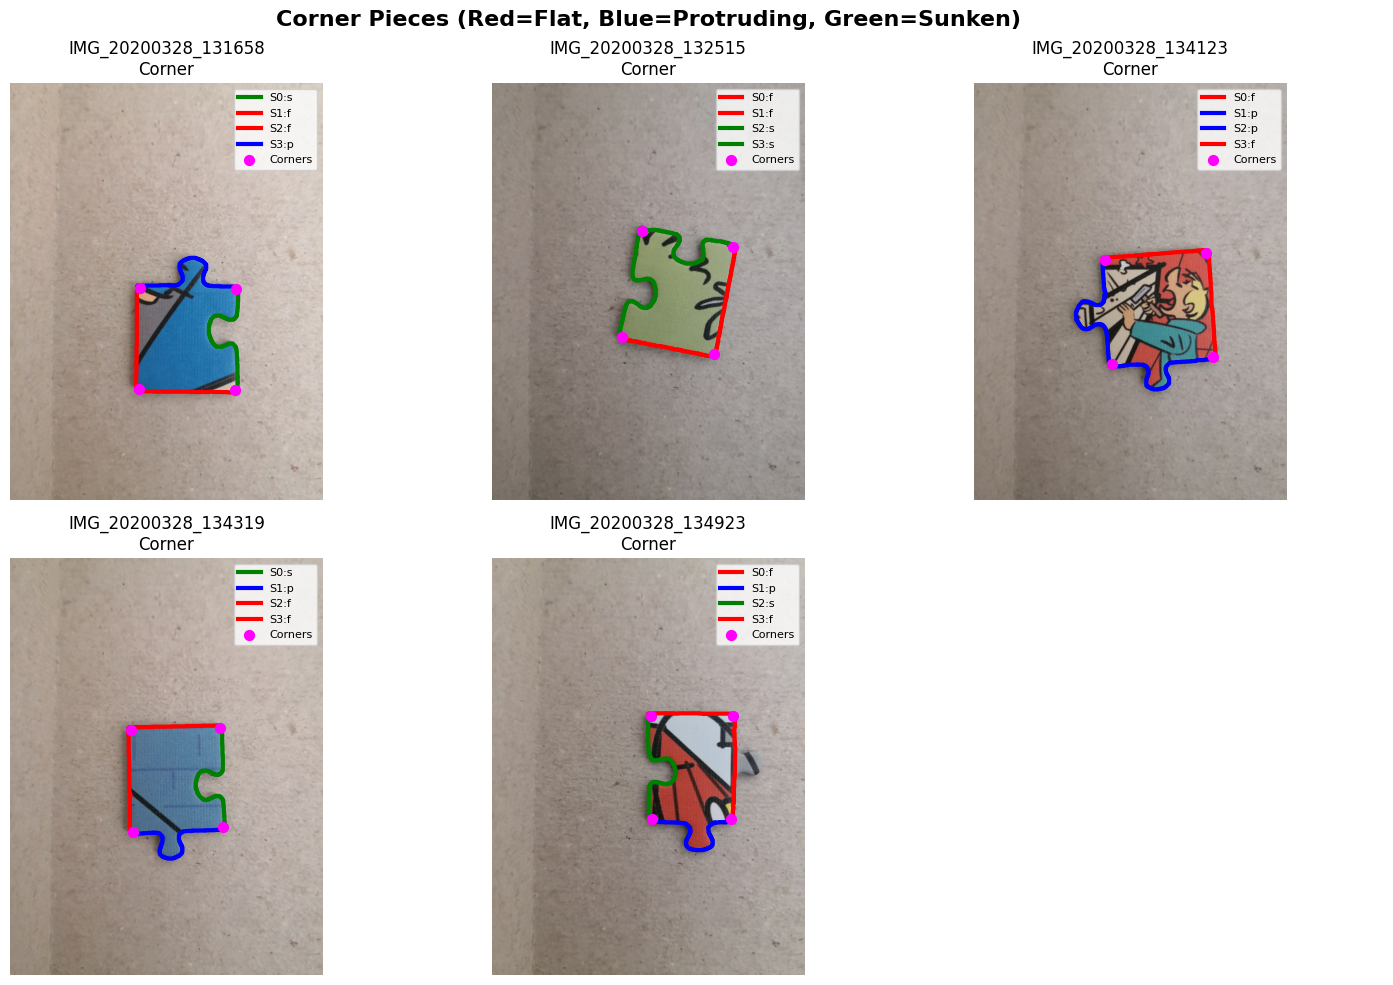


Visualizing edge pieces...


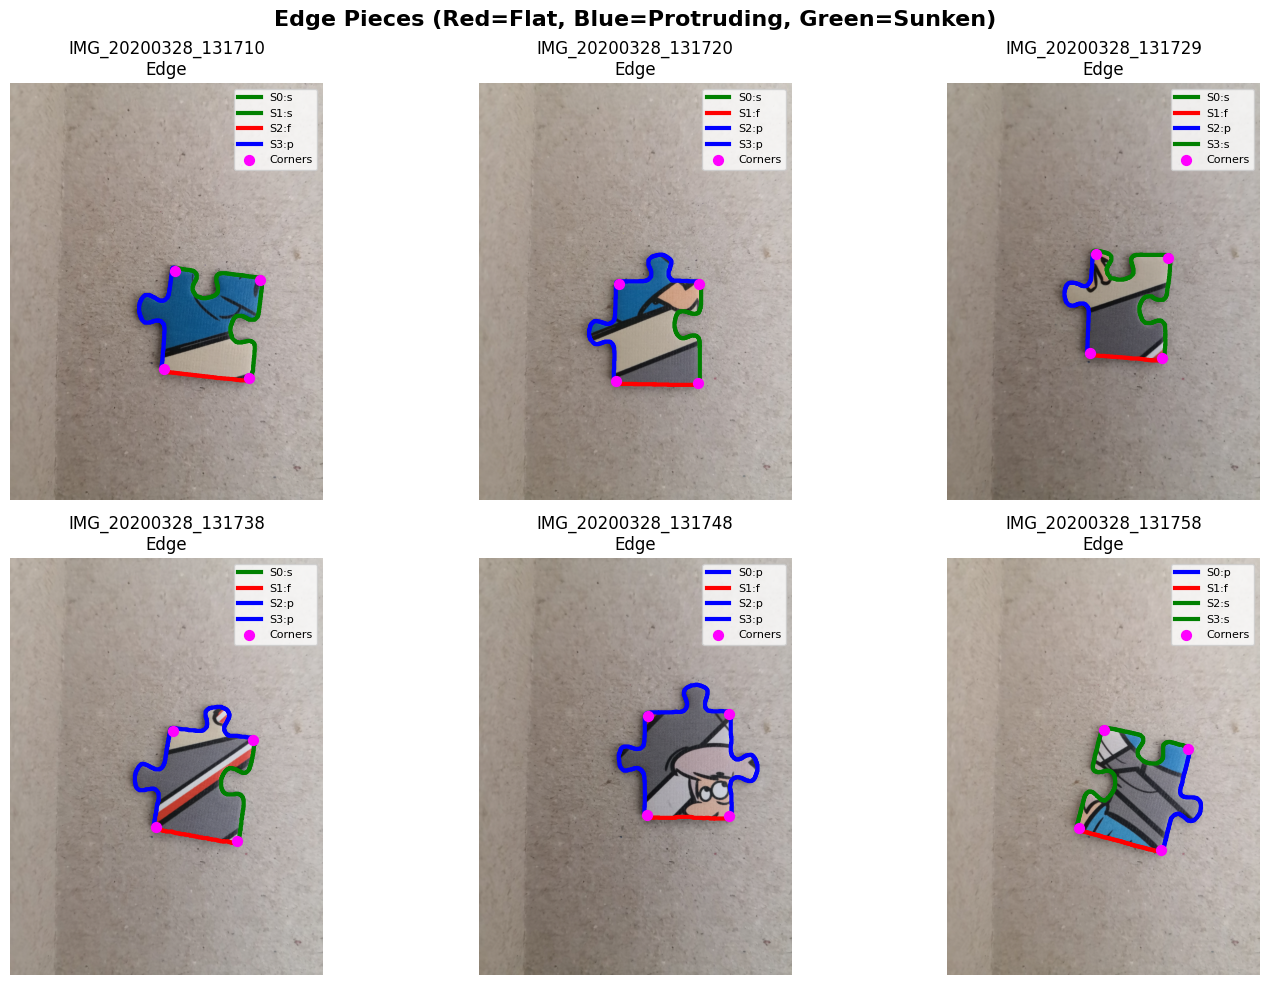


Visualizing interior pieces...


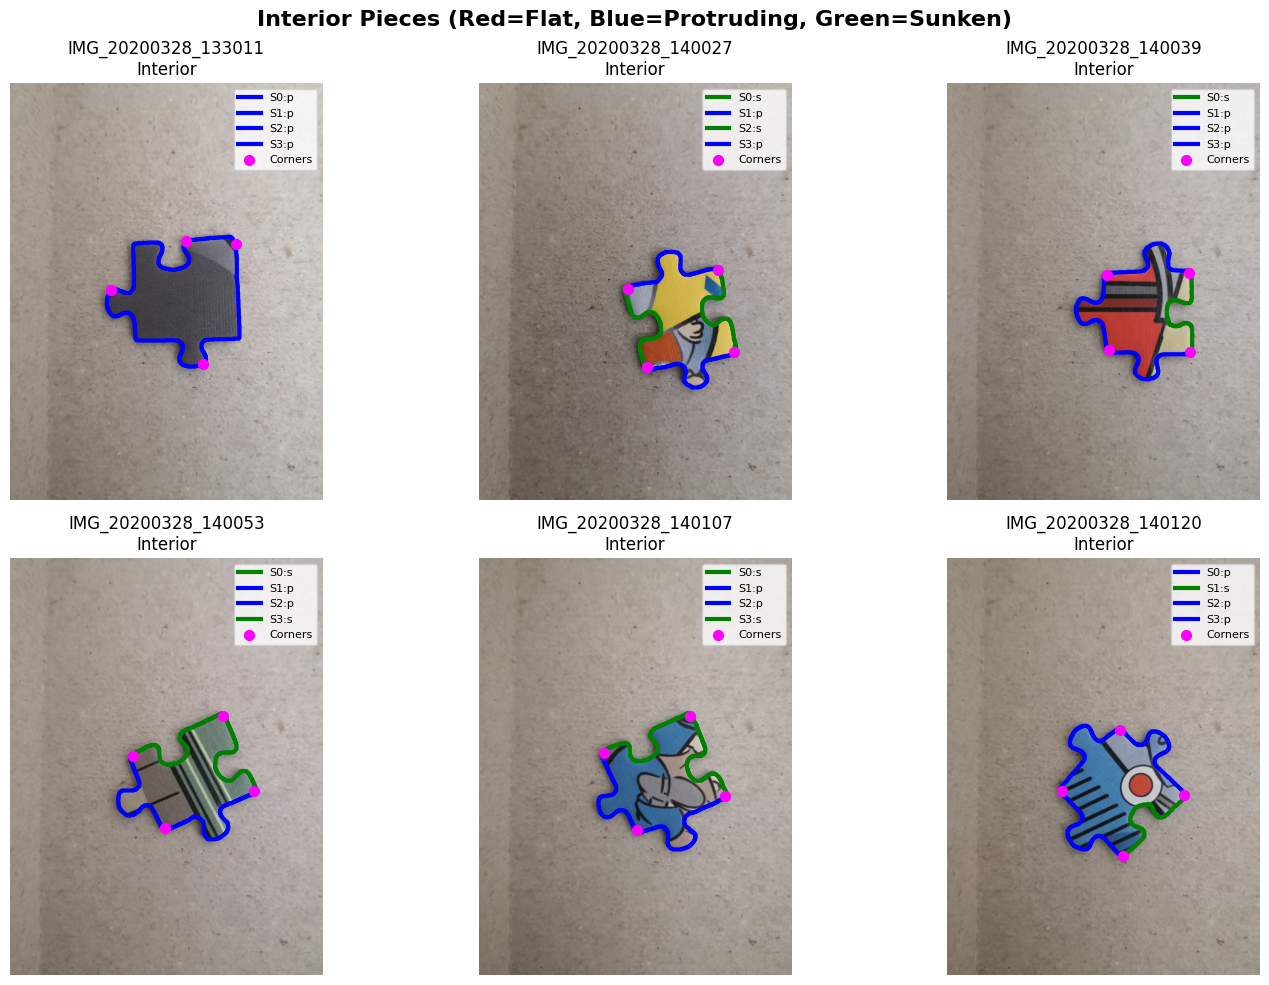

In [559]:
def visualize_pieces_by_type(piece_type, n_samples=6):
    """Visualize sample pieces of a given type"""
    samples = []
    
    for img_path in all_images:
        if len(samples) >= n_samples:
            break
        
        piece_id = img_path.stem
        img, mask = load_piece(piece_id)
        contour, corners = extract_contour_and_corners(mask)
        sides = extract_sides(contour, corners)
        
        side_types_piece = []
        for side in sides:
            norm_side, _ = normalize_side_with_color(side, img, mask)
            side_type = classify_side(norm_side)
            side_types_piece.append(side_type)
        
        # Determine piece type
        num_flat = side_types_piece.count('flat')
        if num_flat == 0:
            ptype = 'interior'
        elif num_flat == 1:
            ptype = 'edge'
        else:
            ptype = 'corner'
        
        if ptype == piece_type:
            samples.append((piece_id, img, sides, side_types_piece, corners))
    
    if len(samples) == 0:
        print(f"No {piece_type} pieces found")
        return
    
    # Visualize
    rows = (len(samples) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    # Always make axes a 1D list
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, (piece_id, img, sides, side_types_piece, corners) in enumerate(samples):
        ax = axes[idx]
        ax.imshow(img)
        
        # Draw sides with different colors
        colors = {'flat': 'red', 'protruding': 'blue', 'sunken': 'green'}
        for i, (side, stype) in enumerate(zip(sides, side_types_piece)):
            ax.plot(side[:, 0], side[:, 1], color=colors[stype], linewidth=3, label=f'S{i}:{stype[0]}')

        # Draw corners
        ax.scatter(corners[:, 0], corners[:, 1], c='magenta', s=50, zorder=5, marker='o', label='Corners')

        ax.set_title(f"{piece_id}\n{piece_type.capitalize()}")
        ax.legend(loc='upper right', fontsize=8)
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f"{piece_type.capitalize()} Pieces (Red=Flat, Blue=Protruding, Green=Sunken)", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples of each type
for ptype in ['corner', 'edge', 'interior']:
    print(f"\nVisualizing {ptype} pieces...")
    visualize_pieces_by_type(ptype, n_samples=6)